![Banner](img/AI_Special_Program_Banner.jpg)

# Deep Neural Networks - Exercise - Sample Solution
---
Instructions are given in <span style="color:blue">blue</span> color.

## Overview
- [Task 1: Train a model for Fashion MNIST](#Task-1:-Train-a-model-for-Fashion-MNIST)
  - [Task 1.1: Import helper functions](#Task-1.1:-Import-helper-functions)
  - [Task 1.2: Use FashionMNIST](#Task-1.2:-Use-FashionMNIST)
  - [Task 1.3: Create a model and use the appropriate device](#Task-1.3:-Create-a-model-and-use-the-appropriate-device)
  - [Task 1.4: Train the model](#Task-1.4:-Train-the-model)
  - [Task 1.5: Check model quality](#Task-1.5:-Check-model-quality)
- [Task 2: Use the model for inference](#Task-2:-Use-the-model-for-inference)
  - [Task 2.1: Inference and visualization](#Task-2.1:-Inference-and-visualization)
  - [Task 2.2: Challenge - visualizing misclassifications](#Task-2.2:-Challenge---visualizing-misclassifications)

---

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# for timing
import datetime as dt

## Task 1: Train a model for Fashion MNIST
In the first part of the exercise, we want to train a model we can use for `FashionMNIST` and get an ideas as to how well it performs.

### Task 1.1: Import helper functions
<span style="color:blue">
    In contrast to what we did in the material notebook, please use the helper functions for the training loop by importing them<br>
    <b>Hint:</b> The helper functions are provided in the script <code>train_loop.py</code>
</span>

In [3]:
# helper functions for the training loop
from train_loop import train, train_for_epochs, validate, plot_history

### Task 1.2: Use FashionMNIST
<span style="color:blue">
Instead of the usual MNIST dataset, use the drop-in replacement <a href=https://github.com/zalandoresearch/fashion-mnist>FashionMNIST</a>.<br>
    <b>Hint:</b> Like the MNIST dataset, <code>FashionMNIST</code> is also directly available from the <code>torchvision.datasets</code> module. Thus, not much has to be changed here ...
</span>

In [4]:
# Download training data and test data from open datasets.
#training_data = datasets.MNIST(
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

#test_data = datasets.MNIST(
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:01<00:00, 16184798.95it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 1166050.17it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 6894897.65it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 47876445.66it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [5]:
BATCH_SIZE = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


--------------




### Task 1.3: Create a model and use the appropriate device
<span style="color:blue">
Make sure you create a neural network and use powerful hardware if available. Do you have to modify anything compared with the material notebook here?
</span>

In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
USE_GPU = True
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weights to the desired device
model = NeuralNetwork().to(device)
model

Using cuda for training the network


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

--------------




### Task 1.4: Train the model
<span style="color:blue">
    Now train the model for 10 epochs as in the MNIST case. Be sure to specify a <code>criterion</code> and an <code>optimizer</code> and record
    the time needed for training.
</span>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
NUM_EPOCHS = 10

# perform training
start_train_mnist = dt.datetime.now()

print(f'FashionMNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, train_dataloader, test_dataloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'FashionMNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

FashionMNIST training started: 2024-01-28 21:36:37.034875


  0%|          | 0/10 [00:00<?, ?it/s]

FashionMNIST training finished: 2024-01-28 21:37:41.808165 (duration: 0:01:04.773290)


### Task 1.5: Check model quality
<span style="color:blue">
    Check how well the final model performs and plot the development of the quality criteria over the epochs.
</span>

In [10]:
# accuracy on the training as well as the test data
train_acc = history['train']['accuracy'][-1]
val_acc = history['val']['accuracy'][-1]
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}')


Train Acc. 71.28
Val Acc. 70.60


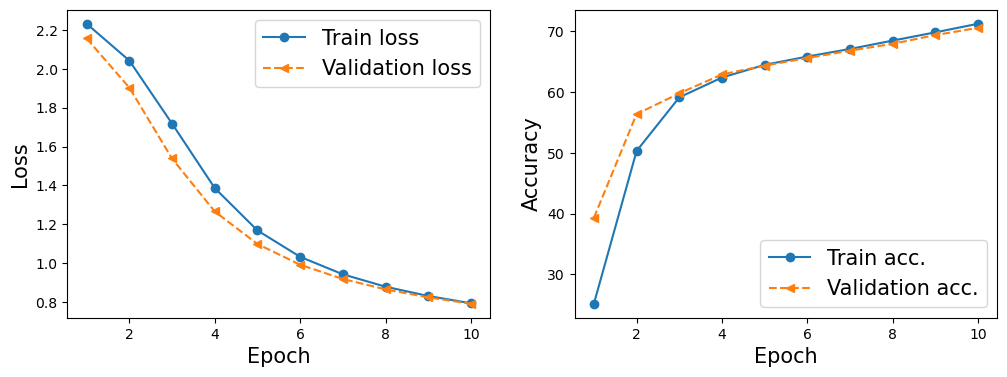

In [11]:
# plot training history
plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])
plt.show()

<span style="color:blue">
    Interpret the current status. Are you sattisfied with the result?
</span>

**Interpretation** The performance of the model is quite a bit worse compared to the situation for the original MNIST. It looks, like quite a bit more training will be necessary to obtain good results ...

--------------

## Task 2: Use the model for inference
Once the model has been trained, we want to use it to classify new images. Ideally, we have an appropriate way of visualizing the results.

### Task 2.1: Inference and visualization
<span style="color:blue">
    Now apply the model 
    <ul>
        <li>to a single image </li>
        <li>to 16 images of a batch provided by the test data loader</li>
    </ul>
    Then visually check the predictions vs. the actual classes for those 16 elements (be sure to arrange the images in a 4 x 4 grid when doing so)<br>
    <b>Hint:</b> The numbers of the classes represent actual items this time. You will therefore need to use a list which <i>maps</i> the numbers to the actual items. You can find the mapping <a href=https://github.com/zalandoresearch/fashion-mnist#Labels>here</a>.
</span>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

#classes = range(10)

# evaluate on single image
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


We can also test an individual batch and even visualize the predictions along with the actual images and the corresponding *ground truth*.

In [13]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

In [14]:
# test on first 16 images of the first set
batch_test = next(iter(test_dataloader))

preds, _ = predict_batch(model, batch_test[0][:16], binary=False)

print(preds)

tensor([9, 2, 1, 1, 6, 1, 6, 4, 7, 7, 2, 5, 7, 3, 4, 1])


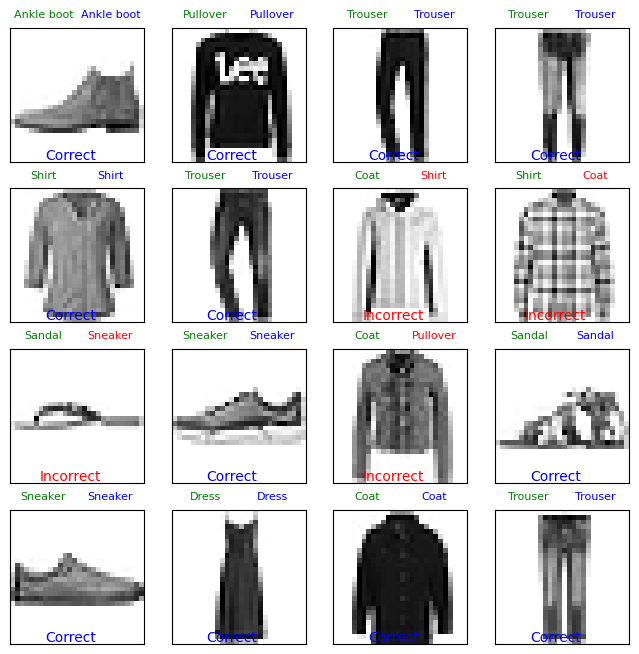

In [15]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        pred = preds[i]
        label = batch_test[1][i]
        pred_txt = classes[pred]
        label_txt = classes[label]
        
        correct = pred == label
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.25, 1.1, '{}'.format(label_txt), 
                size=8, color='green',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.75, 1.1, '{}'.format(pred_txt), 
                size=8, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.45, 0.05, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=10, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)

plt.show()

---

### Task 2.2: Challenge - visualizing misclassifications
<span style="color:blue">
    Find all misclassifications and visualize some of them.
</span>

In [16]:
def find_misclassifications(device, model, dataloader, binary=True, unsqueeze=False):
    mis_list = []
    n = 0
     # Set the model to validation mode
    model.eval() 
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over validation set
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if unsqueeze:
                labels=labels.unsqueeze(1).float()
            outputs = model(inputs)
            # Compute the predicted labels
            if binary:
                predicted = torch.round(outputs)
            else:
                outputs = torch.softmax(outputs, 1)
                _, predicted = torch.max(outputs, 1)
            # Count correct and total predictions
            batch = zip(inputs,labels)
            for data, pred in zip(batch,predicted):
                label = data[1] 
                if label != pred:
                    n += 1
                    mis_list.append((data[0],label,pred))
    return n, mis_list

In [17]:
nmb, misclass = find_misclassifications(device, model, test_dataloader, binary=False)

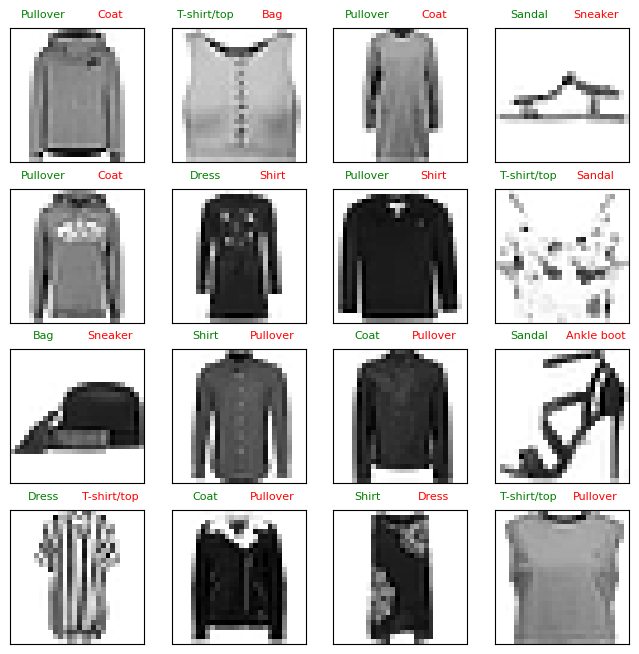

In [20]:
offset = 1000
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        pred = misclass[i+offset][2]
        label = misclass[i+offset][1]
        pred_txt = classes[pred]
        label_txt = classes[label]
        
        correct = pred == label
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = misclass[i+offset][0].view(28, 28).cpu()
        ax.imshow(img, cmap='gray_r')
        ax.text(0.25, 1.1, '{}'.format(label_txt), 
                size=8, color='green',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.75, 1.1, '{}'.format(pred_txt), 
                size=8, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)

plt.show()